<a href="https://colab.research.google.com/github/gmilitao/processamento_LN_DCP_2023/blob/main/trabalho_final_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho final


## Tarefas iniciais

### Importações iniciais

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

### Download das bases

In [ ]:
# montando o drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importação dos tweets avaliados no semestre pelos alunos
tweets_semestre = pd.read_csv("/content/drive/MyDrive/FLS6513_Processamento_linguagem_natural/trabalho final/base_tweets_avaliados_semestre.csv",
                              dtype={"tweet_id":str},
                              parse_dates=['dia_hora'])

tweets_semestre.head(5)

,date_post,tweet_id,content,semana,sobre_vac,sobre_vac_crianca,posicao_vac,posicao_vac_obrigatoria,dificuldade,cod,dia_hora
0,2020-03-20,1241121140988410112,"Senado: Promulgado artigo que protege IBGE, Em...",semana2,Não,Não,Não aplicável,Não aplicável,3 - Difícil,C347,45166.01319444445
1,2020-03-20,1241121140988410112,"Senado: Promulgado artigo que protege IBGE, Em...",semana2,Não,Não,Não aplicável,Não aplicável,2 - Fácil,C478,45180.68958333333
2,2020-03-22,1241825454539120128,ATENÇÃO: programem-se para a vacinação contra ...,semana2,Não,Não,Não aplicável,Não aplicável,2 - Fácil,C567,45161.36388888889
3,2020-03-22,1241825454539120128,ATENÇÃO: programem-se para a vacinação contra ...,semana2,Não,Não,Não aplicável,Não aplicável,2 - Fácil,C814,45159.49722222222
4,2020-09-01,1300918558067770112,Chega a ser inacreditável que o governo esteja...,semana3,Sim,Não,Favorável,Favorável,2 - Fácil,C107,45170.63958333333


In [ ]:
# Importação dos tweets avaliados pelo grupo de trabalho

caminho = 'https://raw.githubusercontent.com/PedroSchmalz/covid19-tweets-brazilian-mayoral-candidates/main/tweets_annotated.csv'


# Carrega o arquivo Excel em um DataFrame
df_annotated = pd.read_csv(caminho, dtype={"tweet_id":str})

df_annotated.head()


,date_post,tweet_id,content,post_vaccine,positions_vac
0,2020-03-19,1240808239224090112,Tenho duas amigas doutorandas na USP. Não estã...,1,1.0
1,2020-03-20,1241121140988410112,"Senado: Promulgado artigo que protege IBGE, Em...",0,NaN
2,2020-03-22,1241825454539120128,ATENÇÃO: programem-se para a vacinação contra ...,0,NaN
3,2020-09-01,1300918558067770112,Chega a ser inacreditável que o governo esteja...,1,1.0
4,2020-10-21,1319042054463290112,"Como prefeito, vamos garantir através da Prefe...",1,1.0


### Recodificações iniciais

In [ ]:
######## Recodificação das variáveis sobre_vac	e	posicao_vac ###########

## Criando um mapeamento de valores numéricos para as categorias

mapeamento_categorias = {
    'Neutro': 0,
    'Favorável': 1,
    'Desfavorável': 3,
    'Não aplicável': 7
}

## Aplicando o mapeamento para criar novas variáveis numéricas para posicao_vac

tweets_semestre['posicao_vac_v2'] = tweets_semestre['posicao_vac'].map(mapeamento_categorias).astype(int)



######## Recodificação da variável positions_vac em df_annotated ###########

# recodificando os casos NA
df_annotated['positions_vac'] = df_annotated['positions_vac'].fillna(7)

# recodificação da positions_vac para adequar à recodificação da posicao_vac_v2

map2 = {
    2 : 0,
    1 : 1,
    3 : 3,
    7 : 7
}

## Aplicando o mapeamento para criar nova variável para positions_vac

df_annotated['positions_vac_2'] = df_annotated['positions_vac'].map(map2)



In [ ]:
# checagem dos códigos da 'positions_vac' original
df_annotated.groupby(['positions_vac']).count()

,date_post,tweet_id,content,post_vaccine,positions_vac_2
positions_vac,,,,,
0.0,1,1,1,1,0
1.0,3999,3999,3999,3999,3999
2.0,2167,2167,2167,2167,2167
3.0,252,252,252,252,252
7.0,637,637,637,637,637


In [ ]:
df_annotated[df_annotated['positions_vac']== 0]

,date_post,tweet_id,content,post_vaccine,positions_vac,positions_vac_2
4465,2021-04-11,1381270931113398016,"Olá, pessoal! Hoje iniciamos a vacinação de pr...",1,0.0,NaN


O tweet_id 1381270931113398016 está com um valor inválido na variável 'positions_vac' da base tweets_annotated. Por isso, tweet será eliminado de todas as bases analisadas

In [ ]:
### retirada do tweet_id 1381270931113398016 de todas as bases

df_annotated = df_annotated[df_annotated['tweet_id'] != '1381270931113398016']

tweets_semestre = tweets_semestre[tweets_semestre['tweet_id'] != '1381270931113398016']

In [ ]:
# adequando o tipo de variável da 'positions_vac_2' da df_annotated, para bater com o tipo da 'posicao_vac_v2'
df_annotated['positions_vac_2'] = df_annotated['positions_vac_2'].astype(int)

In [ ]:
# Criação de novas variáveis dummies para identificação das classificações favoráveis

# criando função para codificação

def codifica(x):
    if x == 1:
        return 1 # favorável como 1
    else:
        return 0 # todo o resto como 0

# aplicando em df_annotated

df_annotated['favo_dummy_annot'] = df_annotated['positions_vac_2'].apply(codifica)

# aplicando em tweets_semestre

tweets_semestre['favo_dummy_ts'] = tweets_semestre['posicao_vac_v2'].apply(codifica)

<ipython-input-68-3eb8a7dd3b01>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_semestre['favo_dummy_ts'] = tweets_semestre['posicao_vac_v2'].apply(codifica)


## Preparação da base do semestre

### Identificação das pessoas mais engajadas X menos engajadas

In [ ]:
# encontrando a quantidade de tweets anotados por semana, por entrevistador

qt_t_p_semana_cod = tweets_semestre[['tweet_id','semana', 'cod']].groupby(['semana', 'cod']).count()

# encontrando a quantidade de semanas trabalhadas

qt_semanas = tweets_semestre[['tweet_id','semana', 'cod']].drop_duplicates(['semana', 'cod']).groupby(['cod']).count()

qt_semanas

,tweet_id,semana
cod,,
C107,10,10
C108,11,11
C127,11,11
C129,4,4
C165,8,8
C217,8,8
C249,11,11
C262,10,10
C301,11,11


In [ ]:
# quantidade total de semanas

tweets_semestre['semana'].nunique()

11

In [ ]:
# descrição da quantidade de semanas trabalhada por codificador:

qt_semanas.describe()['semana']

count    31.000000
mean      8.322581
std       3.438867
min       1.000000
25%       5.500000
50%      10.000000
75%      11.000000
max      11.000000
Name: semana, dtype: float64

In [ ]:
# quantidade de entrevistadores para cada quantidade de semanas

qt2 = qt_semanas.groupby(['semana']).count()

qt2
# Primeira coluna traz a quantidade de semanas. segunda coluna traz a quantidade
# de alunos que codificaram cada quantidade de semanas. 15 alunos codificaram as 11 semanas

,tweet_id
semana,
1,1
2,3
4,2
5,2
6,1
8,4
10,3
11,15


In [ ]:
# soma comulativa da quantidade de alunos por quantidade de semanas

qt2['tweet_id'].cumsum()

semana
1      1
2      4
4      6
5      8
6      9
8     13
10    16
11    31
Name: tweet_id, dtype: int64

A partir desses resultados, uma divisão será:

- menos engajados: trabalharam até 8 semanas
- mais engajados: trabalharam 10 ou 11 semanas.

In [ ]:
# Trazendo a informação de quantidade de semanas que cada cod trabalhou para tweets_semestre

tweets_semestre['qt_semanas'] = tweets_semestre['cod'].map(qt_semanas['semana'])

tweets_semestre.head()

,date_post,tweet_id,content,semana,sobre_vac,sobre_vac_crianca,posicao_vac,posicao_vac_obrigatoria,dificuldade,cod,dia_hora,posicao_vac_v2,favo_dummy_ts,qt_semanas
0,2020-03-20,1241121140988410112,"Senado: Promulgado artigo que protege IBGE, Em...",semana2,Não,Não,Não aplicável,Não aplicável,3 - Difícil,C347,45166.01319444445,7,0,11
1,2020-03-20,1241121140988410112,"Senado: Promulgado artigo que protege IBGE, Em...",semana2,Não,Não,Não aplicável,Não aplicável,2 - Fácil,C478,45180.68958333333,7,0,11
2,2020-03-22,1241825454539120128,ATENÇÃO: programem-se para a vacinação contra ...,semana2,Não,Não,Não aplicável,Não aplicável,2 - Fácil,C567,45161.36388888889,7,0,11
3,2020-03-22,1241825454539120128,ATENÇÃO: programem-se para a vacinação contra ...,semana2,Não,Não,Não aplicável,Não aplicável,2 - Fácil,C814,45159.49722222222,7,0,8
4,2020-09-01,1300918558067770112,Chega a ser inacreditável que o governo esteja...,semana3,Sim,Não,Favorável,Favorável,2 - Fácil,C107,45170.63958333333,1,1,10


In [ ]:
# criando função para criação de nova variável dicotômica - mais engajados X menos engajados

def codifica1(x):
    if x <= 8:
        return 0 # menos engajado
    else:
        return 1 # mais engajado

tweets_semestre['engaj_cod'] = tweets_semestre['qt_semanas'].apply(codifica1)

# criando variável texto
map_engaj = {
    0 : 'Menos engajado',
    1 : 'Mais engajado'
}

tweets_semestre['engaj'] = tweets_semestre['engaj_cod'].map(map_engaj)


### Identificação do tipo de divergência entre base do semestre e anotações do grupo de trabalho



In [ ]:
# trazendo classificações da df_annotated para a tweets_semestre
tweets_semestre = tweets_semestre.merge(df_annotated[['tweet_id','post_vaccine',	'positions_vac', 'positions_vac_2', 'favo_dummy_annot']], on='tweet_id')

In [ ]:
# Criação da variável com o TIPO DE DIVERGÊNCIA entre anotadores do semestre e
# anotadores do grupo de trabalho

tweets_semestre['divergencia'] = abs(tweets_semestre['posicao_vac_v2'] - tweets_semestre['positions_vac_2'])


# criação de variável com a categorização do tipo de divergência

maptipo = {
    0 : 'Mesma avaliação',
    1 : 'Favorável-Neutro',
    2 : 'Favorável-Desfavorável',
    3 : 'Neutro-Desfavorável',
    4 : 'Desfavorável-Não aplicável',
    6 : 'Favorável-Não aplicável',
    7 : 'Neutro-Não aplicável'
}

## Aplicando o mapeamento para criar nova variável para positions_vac

tweets_semestre['tipo_divergencia'] = tweets_semestre['divergencia'].map(maptipo)


In [ ]:
## Criação de variável dummy para "mesma anotação X anotação diferente"

def cod_anot(x):
    if x == 0:
        return 1 # mesma anotação
    else:
        return 0 # anotação diferente

tweets_semestre['diverg_dummy'] = tweets_semestre['divergencia'].apply(cod_anot)

### Separação das bases



Separação das bases de modo a ficar com duas bases com tweets avaliados apenas 1 vez.

In [ ]:

# Semente para reprodutibilidade
semente = 42

# Nova coluna para contar a quantidade de codificadores para cada tweet
tweets_semestre['quant_cod'] = tweets_semestre.groupby('tweet_id')['tweet_id'].transform('count')

# separando tweets anotados por um codificador
ts_coded_once = tweets_semestre[tweets_semestre['quant_cod'] == 1]

# separando tweets anotados por dois codificadores
ts_coded_twice = tweets_semestre[tweets_semestre['quant_cod'] == 2]


In [ ]:
####### Divisão aleatória da base com tweets avaliados DUAS VEZES ##############

# selecionando aleatoriamente 1 anotação de cada tweet para a parte 1
ts_coded_twice_part1 = ts_coded_twice.groupby('tweet_id', group_keys=False).apply(lambda x: x.sample(1, random_state = semente))
# selecionando o restante para a parte 2
ts_coded_twice_part2 = ts_coded_twice.drop(ts_coded_twice_part1.index).sample(frac=1.0)



In [ ]:
####### Divisão aleatória da base com tweets avaliados UMA VEZ ##############

ts_coded_once_part1 = ts_coded_once.sample(frac=0.5,random_state = semente)
ts_coded_once_part2 = ts_coded_once.drop(ts_coded_once_part1.index).sample(frac=1.0)


In [ ]:
####### Criando as bases A e B, cada uma com apenas uma avaliação de cada tweet ##############

# Concatenando os dataframes para chegar à separação das bases
ts_baseA = pd.concat([ts_coded_once_part1, ts_coded_twice_part1])
ts_baseB = pd.concat([ts_coded_once_part2, ts_coded_twice_part2])



Checagem se há duplicidade de tweet_id em cada base. O correto é que não haja.

In [ ]:
# CHECANDO SE HÁ DUPLICIDADE NA 'tweet_id' em cada base

dupbaseA = ts_baseA['tweet_id'].duplicated().sum()

dupbaseB = ts_baseB['tweet_id'].duplicated().sum()

print('Número de tweets duplicados na ts_baseA:', dupbaseA)
print('Número de tweets duplicados na ts_baseB:', dupbaseB)

Número de tweets duplicados na ts_baseA: 0
Número de tweets duplicados na ts_baseB: 0


Separação das bases em 4:

* Engajados base A
* Engajados base B
* Não engajados base A
* Não engajados base B

In [ ]:
ts_baseA_engaj = ts_baseA[ts_baseA['engaj_cod'] == 1]

ts_baseB_engaj = ts_baseB[ts_baseB['engaj_cod'] == 1]

ts_baseA_Nengaj = ts_baseA[ts_baseA['engaj_cod'] == 0]

ts_baseB_Nengaj = ts_baseB[ts_baseB['engaj_cod'] == 0]


print('Tamanho base semestre:', len(tweets_semestre))
print('Tamanho da base A engajados:', len(ts_baseA_engaj))
print('Tamanho da base B engajados:', len(ts_baseB_engaj))
print('Tamanho da base A não engajados:', len(ts_baseA_Nengaj))
print('Tamanho da base B não engajados:', len(ts_baseB_Nengaj))


Tamanho base semestre: 9938
Tamanho da base A engajados: 3821
Tamanho da base B engajados: 3836
Tamanho da base A não engajados: 1148
Tamanho da base B não engajados: 1133


In [ ]:
## Fazendo base completa incluindo classificação se, na base separada, foi para base A ou B

ts_2 = pd.concat([ts_baseA.assign(Base='Base A'), ts_baseB.assign(Base='Base B')])



9938

## Comparação das classificações entre as bases

### Matriz de confusão entre classificações

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# fazer 4 matrizes de confusão, uma para cada base

mat_A_engaj = confusion_matrix(ts_baseA_engaj['positions_vac_2'], ts_baseA_engaj['posicao_vac_v2'], labels=[0, 1, 3, 7])

mat_B_engaj = confusion_matrix(ts_baseB_engaj['positions_vac_2'], ts_baseB_engaj['posicao_vac_v2'], labels=[0, 1, 3, 7])

mat_A_Nengaj = confusion_matrix(ts_baseA_Nengaj['positions_vac_2'], ts_baseA_Nengaj['posicao_vac_v2'], labels=[0, 1, 3, 7])

mat_B_Nengaj = confusion_matrix(ts_baseB_Nengaj['positions_vac_2'], ts_baseB_Nengaj['posicao_vac_v2'], labels=[0, 1, 3, 7])

### Gráfico
# Define nomes das classes
class_names = ['N', 'F', 'D', 'NA']



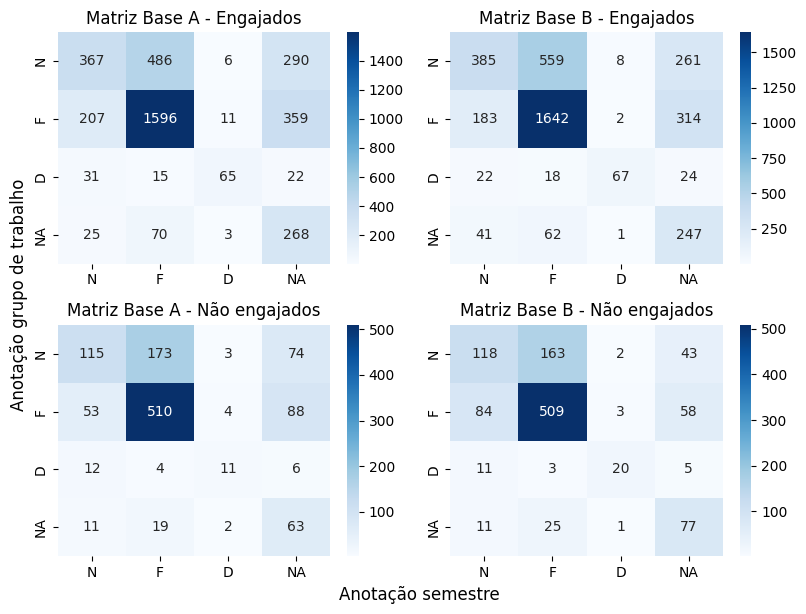

In [ ]:
# criação da estrutura do gráfico
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)


#### criando cada gráfico

## Gráfico da matriz de confusão da base A - engajados
sns.heatmap(mat_A_engaj,
            annot=True,
            fmt='d',
            cmap='Blues', # Cor da matriz
            xticklabels=class_names,
            yticklabels=class_names,
            ax=ax1)

# ax1.set_xlabel('Anotação semestre')
# ax1.set_ylabel('Anotação grupo de trabalho')
ax1.set_title('Matriz Base A - Engajados')

## Gráfico da matriz de confusão da base B - engajados
sns.heatmap(mat_B_engaj,
            annot=True,
            fmt='d',
            cmap='Blues', # Cor da matriz
            xticklabels=class_names,
            yticklabels=class_names,
            ax = ax2)

# ax2.set_xlabel('Anotação semestre')
# ax2.set_ylabel('Anotação grupo de trabalho')
ax2.set_title('Matriz Base B - Engajados')

## Gráfico da matriz de confusão da base A - Não engajados
sns.heatmap(mat_A_Nengaj,
            annot=True,
            fmt='d',
            cmap='Blues', # Cor da matriz
            xticklabels=class_names,
            yticklabels=class_names,
            ax = ax3)

# ax3.set_xlabel('Anotação semestre')
# ax3.set_ylabel('Anotação grupo de trabalho')
ax3.set_title('Matriz Base A - Não engajados')

## Gráfico da matriz de confusão da base B - Engajados
sns.heatmap(mat_B_Nengaj,
            annot=True,
            fmt='d',
            cmap='Blues', # Cor da matriz
            xticklabels=class_names,
            yticklabels=class_names,
            ax = ax4)

# ax4.set_xlabel('Anotação semestre')
# ax4.set_ylabel('Anotação grupo de trabalho')
ax4.set_title('Matriz Base B - Não engajados')

# Adiciona rótulos para os eixos X e Y do objeto fig como um todo
fig.text(0.5, 0.04, 'Anotação semestre', ha='center', va='center', fontsize=12)
fig.text(0.06, 0.5, 'Anotação grupo de trabalho', ha='center', va='center', rotation='vertical', fontsize=12)

# Ajusta a posição vertical dos textos
fig.texts[0].set_position((0.5, 0.00))  # Ajusta a posição do texto do eixo X
fig.texts[1].set_position((0.00, 0.5))  # Ajusta a posição do texto do eixo Y

plt.tight_layout()  # Adiciona espaçamento automático entre os subgráficos
plt.show()

### Proporções dos tipos de diferença

In [ ]:
# cálculo da concordância no total da base de anotações

concor = ts_2[['tweet_id', 'tipo_divergencia']].groupby(['tipo_divergencia']).size().reset_index()
concor.columns = ['tipo_divergencia', 'n']
concor['prop'] = concor['n'] / concor['n'].sum()

concor

,tipo_divergencia,n,prop
0,Desfavorável-Não aplicável,64,0.006440
1,Favorável-Desfavorável,60,0.006037
2,Favorável-Neutro,1908,0.191990
3,Favorável-Não aplicável,995,0.100121
4,Mesma avaliação,6060,0.609781
5,Neutro-Desfavorável,95,0.009559
6,Neutro-Não aplicável,756,0.076072


In [ ]:
## cálculo das proporções de tipos de divergência por base (A ou B)

# criando a contagem em números absolutos em um novo dataframe (reset_index necessário para criar novo df)
concb = ts_2[['tweet_id', 'tipo_divergencia', 'Base']].groupby(['Base','tipo_divergencia']).size().reset_index()
concb.columns = ['Base', 'tipo_divergencia', 'n']
grouped_concb = concb.groupby('Base')
# calculando a soma de n dentro de cada grupo
soma_por_grupo = grouped_concb['n'].transform('sum')
# nova coluna de proporção
concb['prop'] = concb['n'] / soma_por_grupo
# calculando o erro padrão (standard error) das proporções
concb['se_prop'] = np.sqrt(concb['prop'] * (1 - concb['prop']) / soma_por_grupo)
# calculando margem de erro das proporções considerando um intervalo de 95% de confiança
concb['me_prop'] = 1.96 * concb['se_prop']

concb

,Base,tipo_divergencia,n,prop,se_prop,me_prop
0,Base A,Desfavorável-Não aplicável,33,0.006641,0.001152,0.002258
1,Base A,Favorável-Desfavorável,34,0.006842,0.001169,0.002292
2,Base A,Favorável-Neutro,919,0.184947,0.005508,0.010795
3,Base A,Favorável-Não aplicável,536,0.107869,0.004401,0.008625
4,Base A,Mesma avaliação,2995,0.602737,0.006942,0.013606
5,Base A,Neutro-Desfavorável,52,0.010465,0.001444,0.002829
6,Base A,Neutro-Não aplicável,400,0.080499,0.003860,0.007565
7,Base B,Desfavorável-Não aplicável,31,0.006239,0.001117,0.002189
8,Base B,Favorável-Desfavorável,26,0.005232,0.001023,0.002006
9,Base B,Favorável-Neutro,989,0.199034,0.005664,0.011102


In [ ]:
####### criação de função para criação de bases de proporção por nível de engajamento dos alunos

def proporcoes(x):
  # criando a contagem em números absolutos em um novo dataframe (reset_index necessário para criar novo df)
  x1 = x[['tweet_id', 'tipo_divergencia', 'engaj_cod']].groupby(['tipo_divergencia', 'engaj_cod',]).size().reset_index()
  # renomeando as colunas
  x1.columns = ['tipo_divergencia', 'engaj_cod', 'n']
  # agrupando por "engaj"
  grouped_df = x1.groupby('engaj_cod')
  # calculando a soma de n dentro de cada grupo
  soma_n_por_grupo = grouped_df['n'].transform('sum')
  # nova coluna de proporção
  x1['prop'] = x1['n'] / soma_n_por_grupo
  # calculando o erro padrão (standard error) das proporções
  x1['se_prop'] = np.sqrt(x1['prop'] * (1 - x1['prop']) / soma_n_por_grupo)
  # calculando margem de erro das proporções considerando um intervalo de 95% de confiança
  x1['me_prop'] = 1.96 * x1['se_prop']
  # criando coluna com os labels do enhajamento
  x1['engaj'] = x1['engaj_cod'].map(map_engaj)
  return x1





In [ ]:
# proporções de tipos de divergência na base total de anotações

prop_basets = proporcoes(ts_2)
prop_basets

,tipo_divergencia,engaj_cod,n,prop,se_prop,me_prop,engaj
0,Desfavorável-Não aplicável,0,14,0.006138,0.001635,0.003205,Menos engajado
1,Desfavorável-Não aplicável,1,50,0.006530,0.000920,0.001804,Mais engajado
2,Favorável-Desfavorável,0,14,0.006138,0.001635,0.003205,Menos engajado
3,Favorável-Desfavorável,1,46,0.006008,0.000883,0.001731,Mais engajado
4,Favorável-Neutro,0,473,0.207365,0.008489,0.016638,Menos engajado
5,Favorável-Neutro,1,1435,0.187410,0.004460,0.008741,Mais engajado
6,Favorável-Não aplicável,0,190,0.083297,0.005786,0.011340,Menos engajado
7,Favorável-Não aplicável,1,805,0.105133,0.003505,0.006870,Mais engajado
8,Mesma avaliação,0,1423,0.623849,0.010143,0.019880,Menos engajado
9,Mesma avaliação,1,4637,0.605590,0.005585,0.010947,Mais engajado


In [ ]:
# proporções de tipos de divergência nas bases A e B

prop_baseA = proporcoes(ts_baseA)
prop_baseB = proporcoes(ts_baseB)

### Gráficos dos tipos de diferença



<ipython-input-154-bcca6ba4c4aa>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x['tipo_divergencia'].unique(), rotation=90, ha="right")
<ipython-input-154-bcca6ba4c4aa>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x['tipo_divergencia'].unique(), rotation=90, ha="right")


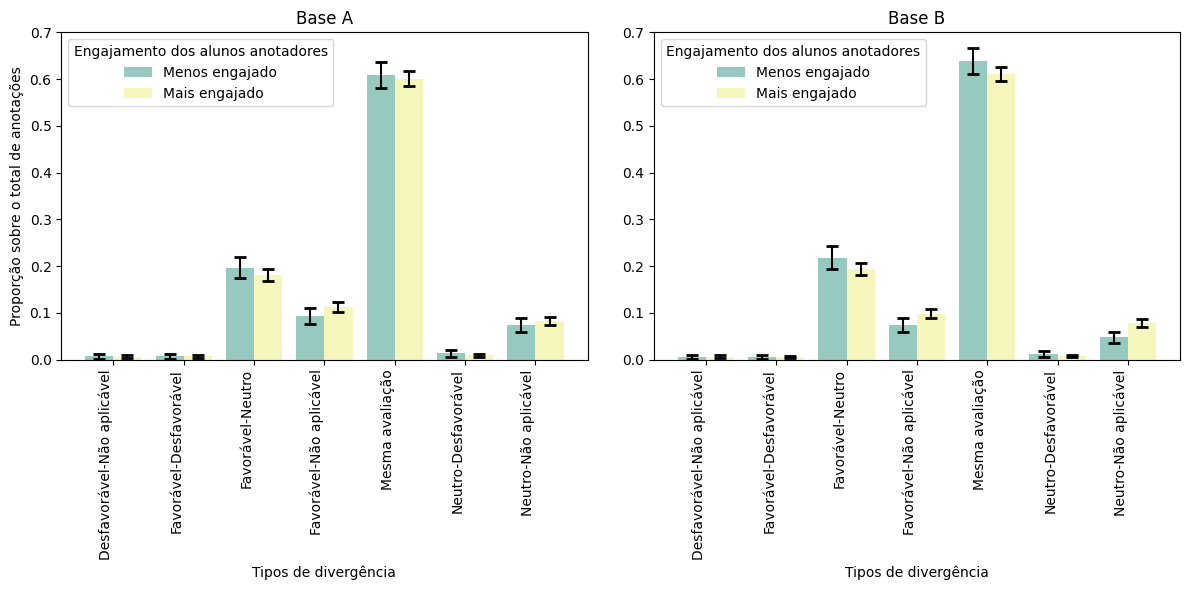

In [ ]:

import seaborn as sns

limites_y = (0, 0.7)

def grafico(ax, x, titulo_graf=None, ylabel=None):
    ylabel = ylabel or True
    sns.barplot(data=x, x='tipo_divergencia', y='prop', hue='engaj', palette='Set3', ax=ax)
    ax.set_title(titulo_graf)
    ax.set_xlabel('Tipos de divergência')
    ax.set_ylabel(ylabel)
    ax.legend(title='Engajamento dos alunos anotadores')

    for i, tipo_divergencia in enumerate(x['tipo_divergencia'].unique()):
        for j, engajamento in enumerate(x['engaj'].unique()):
            subset = x[(x['tipo_divergencia'] == tipo_divergencia) & (x['engaj'] == engajamento)]
            if engajamento == 'Menos engajado':
                x_position = i - 0.2
            else:
                x_position = i + 0.2
            ax.errorbar(
                x=x_position,
                y=subset['prop'],
                yerr=subset['me_prop'],
                fmt='none',
                capsize=4,
                color='black',
                capthick=2,
            )
    ax.set_xticklabels(x['tipo_divergencia'].unique(), rotation=90, ha="right")
    ax.set_ylim(limites_y)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 linha, 2 colunas

grafico(axes[0], prop_baseA, titulo_graf = 'Base A', ylabel = 'Proporção sobre o total de anotações')
grafico(axes[1], prop_baseB, titulo_graf = 'Base B', ylabel = ' ')

plt.tight_layout()  # Ajusta automaticamente a disposição dos subplots para evitar sobreposição
plt.show()

### Alpha de Krippendorff na base A e na base B



In [ ]:
#instalar o pacote
!pip install krippendorff

#importando o pacote
import krippendorff


#### Na base completa

In [ ]:
list1 = ts_2['positions_vac_2']
list2 = ts_2['posicao_vac_v2']
alpha_geral = krippendorff.alpha([list1,list2])

alpha_geral

0.287558710638528

#### Nas bases A e B

In [ ]:

# função para cálculo do alpha agrupado para cada nível de engajamento

def alpha_krippendorff(x, nome_base):
  results_alpha = {'engaj': [], 'alpha': [], 'base' : []}
  for i, engajamento in enumerate(x['engaj'].unique()):
    subset = x[x['engaj'] == engajamento]
    lista1 = subset['positions_vac_2']
    lista2 = subset['posicao_vac_v2']
    alpha = krippendorff.alpha([lista1,lista2])
    results_alpha['engaj'].append(engajamento)
    results_alpha['alpha'].append(alpha)
    results_alpha['base'].append(nome_base)
  return pd.DataFrame(results_alpha)

alpha_krippendorff(ts_baseA, 'Base A')
alpha_krippendorff(ts_baseB, 'Base B')

alpha_krip = pd.concat([alpha_krippendorff(ts_baseA, 'Base A'), alpha_krippendorff(ts_baseB, 'Base B')])

In [ ]:
ak = alpha_krip
ak['alpha'] = ak['alpha'].round(2)
ak

,engaj,alpha,base
0,Menos engajado,0.26,Base A
1,Mais engajado,0.27,Base A
0,Mais engajado,0.28,Base B
1,Menos engajado,0.43,Base B


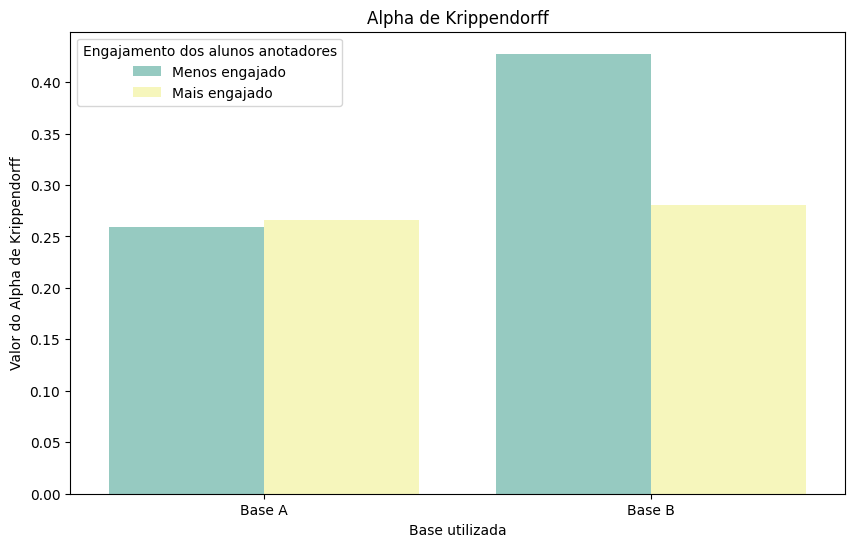

In [ ]:
# criando o gráfico:

fig = plt.subplots(figsize=(10, 6))
sns.barplot(data=alpha_krip, x='base', y='alpha', hue='engaj', palette='Set3')
plt.title('Alpha de Krippendorff')
plt.xlabel('Base utilizada')
plt.ylabel('Valor do Alpha de Krippendorff')
plt.legend(title='Engajamento dos alunos anotadores')
plt.show()


### Bootstrap

Referência: página 221 JAMES, G., WITTEN, D., HASTIE, T., TIBSHIRANI, R., & TAYLOR, J. (2023). An introduction to statistical learning: With applications in python. Springer Nature. (texto ISL_Python-209-236_obrigatorio aula 9).





#### Bootstrap proporção de anotações iguais sobre o total de anotações. Engajados X Não engajados

Bootstrap feito considerando a classificação dummy "mesma anotação x anotação diferente", na base "tweets semestre" como um todo.

Objetivo é identificar se a proporção de concordância entre anotações feitas pelos anotadores mais engajados é maior do que a proporção de concordância entre anotações feitas pelos anotadores menos engajados

In [ ]:

# função para criação das proporção de favoráveis X não favoráveis na base "tweets_semestre" como um todo


def prop_boots(x, idx):
  # Criando um DataFrame para uma parte da amostra usando os índices selecionados em idx
  sampled_data = x.iloc[idx]
  # criando a contagem em números absolutos em um novo dataframe (reset_index necessário para criar novo df)
  x1 = sampled_data[['tweet_id', 'diverg_dummy', 'engaj_cod']].groupby(['diverg_dummy', 'engaj_cod',]).size().reset_index()
  # renomeando as colunas
  x1.columns = ['diverg_dummy', 'engaj_cod', 'n']
  # agrupando por "engaj"
  grouped_df = x1.groupby('engaj_cod')
  # calculando a soma de n dentro de cada grupo
  soma_n_por_grupo = grouped_df['n'].transform('sum')
  # nova coluna de proporção
  x1['prop'] = x1['n'] / soma_n_por_grupo
  # filtrando apenas casos em que 'diverg_dummy' == 1
  x1 = x1[x1['diverg_dummy'] == 1]
  # pegando apenas a coluna "prop", isto é, só a proporção de concordância
  x1 = x1['prop'].reset_index(drop=True)
  return x1


In [ ]:

## função genérica para cálculo do erro padrão de estimativas usando bootstrap
# FUNÇÃO PRESENTE EM:
# James, Gareth; Witten, Daniela; Hastie, Trevor and Tibshirani, Robert. (2022). “
# Resampling Methods” in “An Introduction to Statistical Learning: with Applications in R”.
# Springer.

def boot_SE(func ,
            D,
            n=None,
            B=10000,
            seed=0):
  rng = np.random.default_rng(seed)
  first_ , second_ = 0, 0
  n = n or D.shape[0]
  D_reset = D.reset_index(drop=True)
  for _ in range(B):
    idx = rng.choice(D_reset.index ,
                     n,
                     replace=True)
    value = func(D_reset, idx)
    first_ += value
    second_ += value**2
  return np.sqrt(second_ / B - (first_ / B)**2)


In [ ]:
# aplicação da função para aplicação do bootstrap

SE_prop_boots_ts = boot_SE(prop_boots, tweets_semestre, B=10000, seed=42)

SE_prop_boots_ts

0    0.010194
1    0.005570
Name: prop, dtype: float64

In [ ]:
# pegando as proporções de anotações com a mesma avaliação na tweets_semestre:
prop_mesma_aval_ts = prop_boots(tweets_semestre, list(tweets_semestre.index.values))

prop_mesma_aval_ts

0    0.623849
1    0.605590
Name: prop, dtype: float64

In [ ]:
# trazendo informação do label para a criação do gráfico
prop_mesma_aval_ts = pd.DataFrame(prop_mesma_aval_ts)

prop_mesma_aval_ts['engaj'] = prop_mesma_aval_ts.index.map(map_engaj)

prop_mesma_aval_ts

,prop,engaj
0,0.623849,Menos engajado
1,0.605590,Mais engajado


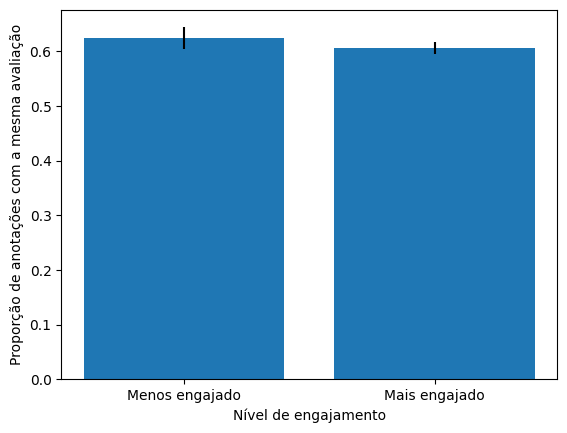

In [ ]:
# gráfico da proporção de mesma avaliação, com margem de erro calculada a partir do bootstrap

plt.bar(prop_mesma_aval_ts['engaj'], prop_mesma_aval_ts['prop'], yerr=SE_prop_boots_ts*1.96)
plt.xlabel('Nível de engajamento')
plt.ylabel('Proporção de anotações com a mesma avaliação')
plt.show()

#### Bootstrap proporção de anotações iguais sobre o total de anotações. Bases A e B. Engajados X Não engajados.

In [ ]:
# prop_boots(ts_baseA, list(ts_baseA.index.values))

# aplicação do bootstrap nas bases A e B para proporções de mesma avaliação

SE_prop_baseA = boot_SE(prop_boots, ts_baseA, B=10000, seed=42)

SE_prop_baseB = boot_SE(prop_boots, ts_baseB, B=10000, seed=42)

SE_prop_baseB

0    0.014415
1    0.007881
Name: prop, dtype: float64

In [ ]:
# calculando novamente as proporções de "mesma avaliação", por engajamento, nas bases A e B

prop_mesmA_A = ts_baseA.reset_index(drop=True)
prop_mesmA_A = prop_boots(prop_mesmA_A, list(prop_mesmA_A.index.values))

prop_mesmA_B = ts_baseB.reset_index(drop=True)
prop_mesmA_B = prop_boots(prop_mesmA_B, list(prop_mesmA_B.index.values))



In [ ]:
#JUNTAR prop_mesmA_A e prop_mesmA_B para formar a base a ser usada no gráfico

dict_proporcoes = {'prop' : [prop_mesmA_A[0],
                             prop_mesmA_A[1],
                             prop_mesmA_B[0],
                             prop_mesmA_B[1]],
                   'se_boots' : [SE_prop_baseA[0],
                                 SE_prop_baseA[1],
                                 SE_prop_baseB[0],
                                 SE_prop_baseB[1]],
                   'base': ['Base A',
                            'Base A',
                            'Base B',
                            'Base B'],
                   'engaj' : ['Menos engajados',
                              'Mais engajados',
                              'Menos engajados',
                              'Mais engajados']}

df_prop_graf = pd.DataFrame(dict_proporcoes)


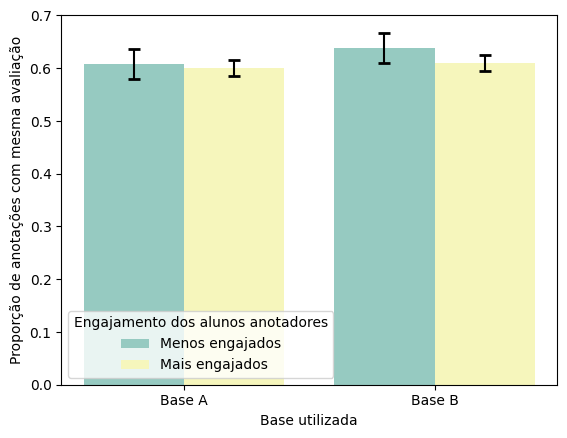

In [ ]:
# gráfico comparando as proporções de mesma avaliação entre mais e menos engajados, entre as bases A e B
# com inclusão da margem de erro calculada com o erro padrão calculado com bootstrap

# criando o gráfico:

fig, ax = plt.subplots()
sns.barplot(data=df_prop_graf, x='base', y='prop', hue='engaj', palette='Set3')
plt.xlabel('Base utilizada')
plt.ylabel('Proporção de anotações com mesma avaliação')
plt.legend(title='Engajamento dos alunos anotadores')
# loop para criação das linhas com o intervalo de 95% de confiança:
for i, base in enumerate(df_prop_graf['base'].unique()):
  for j, engajamento in enumerate(df_prop_graf['engaj'].unique()):
    subset = df_prop_graf[(df_prop_graf['base'] == base) & (df_prop_graf['engaj'] == engajamento)]
    if engajamento == 'Menos engajados': # if para ajustar a posição das linhas de erro
        x_position = i - 0.2
    else:
        x_position = i + 0.2
    ax.errorbar(
        x=x_position,
        y=subset['prop'],
        yerr=subset['se_boots']* 1.96,
        fmt='none',
        capsize=4,
        color='black',
        capthick=2,
    )
plt.show()

#### Bootstrap alpha de krippendorff. Engajados X Não engajados. Base total tweets_semestre

In [ ]:
# função para criação do alpha de krippendorff

def alpha_boots(x, idx):
  # Create a DataFrame for the sampled data using the provided indices
  x1 = x.iloc[idx]
  results_alpha = {'engaj_cod': [], 'alpha': []}
  for i, engajamento in enumerate(x1['engaj_cod'].unique()):
    subset = x1[x1['engaj_cod'] == engajamento]
    lista1 = subset['positions_vac_2']
    lista2 = subset['posicao_vac_v2']
    alpha = krippendorff.alpha([lista1,lista2])
    results_alpha['engaj_cod'].append(engajamento)
    results_alpha['alpha'].append(alpha)
  return pd.DataFrame(results_alpha).set_index('engaj_cod').sort_index()


In [ ]:
# calculando o alpha de krippendorff para cada grupo de engajamento no total da base tweets_semestre
alphas_ts_engaj = alpha_boots(tweets_semestre, list(tweets_semestre.index.values))

# aplicando mapeamento para trazer o label de engaj_cod para alphas_ts_engaj

alphas_ts_engaj['engaj'] = alphas_ts_engaj.index.map(map_engaj)


alphas_ts_engaj

,alpha,engaj
engaj_cod,,
0,0.340053,Menos engajado
1,0.273132,Mais engajado


In [ ]:
# Bootstrap aplicando a função 'alpha_boots'

SE_alphas_ts_engaj = boot_SE(alpha_boots, tweets_semestre, B=10000, seed=42)

SE_alphas_ts_engaj

,alpha
engaj_cod,
0,0.028007
1,0.014146


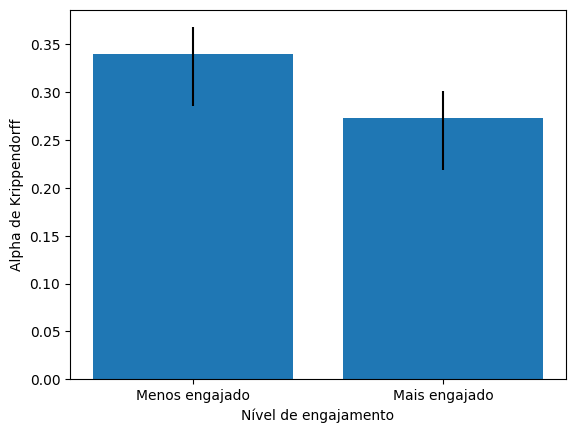

In [ ]:
# Gráfico dos resultados do krippendorff por engajamento, considerando a margem de erro proveniente do SE calculado com o bootstrap


plt.bar(alphas_ts_engaj['engaj'], alphas_ts_engaj['alpha'], yerr=SE_alphas_ts_engaj*1.96)
plt.xlabel('Nível de engajamento')
plt.ylabel('Alpha de Krippendorff')
plt.show()

#### Bootstrap alpha de krippendorff. Engajados X Não engajados. Bases A e B

In [ ]:
# aplicação do bootstrap na base A

SE_alphas_baseA = boot_SE(alpha_boots, ts_baseA, B=10000, seed=42)

SE_alphas_baseB = boot_SE(alpha_boots, ts_baseB, B=10000, seed=42)


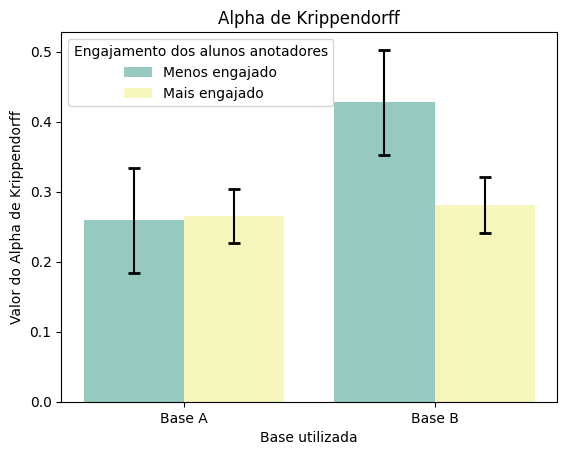

In [ ]:
# gráfico comparando os alpha de krippendorff entre mais e menos engajados, entre as bases A e B
# com inclusão da margem de erro calculada com o erro padrão calculado com bootstrap

# criando o gráfico:

fig, ax = plt.subplots()
sns.barplot(data=alpha_krip, x='base', y='alpha', hue='engaj', palette='Set3')
plt.title('Alpha de Krippendorff')
plt.xlabel('Base utilizada')
plt.ylabel('Valor do Alpha de Krippendorff')
plt.legend(title='Engajamento dos alunos anotadores')
# loop para criação das linhas com o intervalo de 95% de confiança:
for i, base in enumerate(alpha_krip['base'].unique()):
  for j, engajamento in enumerate(alpha_krip['engaj'].unique()):
    subset = alpha_krip[(alpha_krip['base'] == base) & (alpha_krip['engaj'] == engajamento)]
    if engajamento == 'Menos engajado': # if para ajustar a posição das linhas de erro
        x_position = i - 0.2
    else:
        x_position = i + 0.2
    if base == "Base A":
      merroBoost = SE_alphas_baseA.iloc[j] * 1.96
    else:
      merroBoost = SE_alphas_baseB.iloc[j] * 1.96
    ax.errorbar(
        x=x_position,
        y=subset['alpha'],
        yerr=merroBoost,
        fmt='none',
        capsize=4,
        color='black',
        capthick=2,
    )
plt.show()

